# Dublinbikes Project
<img src="https://www.dublinbikes.ie/assets/img/home/accueil-une-bg.jpg" alt="A row of Dublin Bikes in front of Dublin's Custom House" width="800"/>

This project is undertaken for the [Programming for Data Analytics](https://www.atu.ie/courses/higher-diploma-in-science-data-analytics#:~:text=Programming%20for%20Data%20Analytics) module as part of the [Higher Diploma in Science in Data Analytics](https://www.atu.ie/courses/higher-diploma-in-science-data-analytics) at ATU.

The brief for this project was quite broad:

> Write a notebook that demonstrates what you have learned in the Module, if you can not think of an area you wish to explore, then create a project that analyses windspeed for windfarms.

As I have an interest is public transport, library-type sharing systems, and the movement towards better utilisation of public service data, I have decided to interrogate some of the freely available data for the [Dublinbikes](https://www.dublinbikes.ie/) bike-sharing scheme.

In [1]:
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for visualisations
import folium as fl # for mapping
from datetime import datetime 

# set Seaborn visual theme for plots
sns.set()

## Overview

In [2]:
# reading the CSV into a dataframe and getting a quick overview
df = pd.read_csv("https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/6bad1ee7-2c2b-4a52-9567-db7445fc64ff/download/dublinbike-historical-data-2024-01.csv")
df.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,1,2024-01-01 00:00:02,2023-12-31 23:59:40,CLARENDON ROW,31,8,23,OPEN,Clarendon Row,53.3409,-6.26250
1,2,2024-01-01 00:00:02,2023-12-31 23:57:55,BLESSINGTON STREET,20,18,2,OPEN,Blessington Street,53.3568,-6.26814
2,3,2024-01-01 00:00:02,2023-12-31 23:59:33,BOLTON STREET,20,18,2,OPEN,Bolton Street,53.3512,-6.26986
3,4,2024-01-01 00:00:02,2023-12-31 23:49:57,GREEK STREET,20,10,10,OPEN,Greek Street,53.3469,-6.27298
4,5,2024-01-01 00:00:02,2023-12-31 23:51:04,CHARLEMONT PLACE,40,8,32,OPEN,Charlemont Street,53.3307,-6.26018


In [3]:
df['NAME'] = df['NAME'].str.title()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169062 entries, 0 to 169061
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   STATION ID             169062 non-null  int64  
 1   TIME                   169062 non-null  object 
 2   LAST UPDATED           169062 non-null  object 
 3   NAME                   169062 non-null  object 
 4   BIKE_STANDS            169062 non-null  int64  
 5   AVAILABLE_BIKE_STANDS  169062 non-null  int64  
 6   AVAILABLE_BIKES        169062 non-null  int64  
 7   STATUS                 169062 non-null  object 
 8   ADDRESS                169062 non-null  object 
 9   LATITUDE               169062 non-null  float64
 10  LONGITUDE              169062 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 14.2+ MB


The data contains 11 columns:
1. **STATION ID**: a unique identifying digit for each Dublinbike station
2. **TIME**: a timestamp for the data
3. **LAST UPDATED**: when the data was last updated
4. **NAME**: the station name
5. **BIKE_STANDS**: the total number of bike stands at the station
6. **AVAILABLE_BIKE_STANDS**: the number of stands available to deposit a bike
7. **AVAILABLE_BIKES**: the number of bikes available to borrow
8. **STATUS**: the open/closed status of the station
9. **ADDRESS**: the address at which the station is located
10. **LATITUDE**: the co-ordinates of the station's latitude
11. **LONGITUDE**: the co-ordinates of the station's longitude

I can see from the <code>info()</code> overview that there are no null values in the dataset. This will make analysing the data more straightforward. I won't always be this lucky - if I come across null values in another analysis I will need to determine a suitable approach for handling them depending on the nature of the overall dataset - would I remove them entirely; or average them out depending on the values either side of them? Null values need to be considered in their context on each instance.

In [4]:
df['TIME'] = pd.to_datetime(df['TIME'], format="%Y-%m-%d %H:%M:%S")
df['TIME'].dtype

dtype('<M8[ns]')

In [5]:
# extract unique detail to own dataframe
# sort bike stands by ascending
unique_df = df[['NAME', 'BIKE_STANDS','LATITUDE', 'LONGITUDE']].drop_duplicates()
unique_df = unique_df.sort_values(by='BIKE_STANDS', ascending=True)

# Display the resulting dataframe
unique_df.head()

,NAME,BIKE_STANDS,LATITUDE,LONGITUDE
9,Dame Street,16,53.3440,-6.26680
14,Hardwicke Street,16,53.3555,-6.26442
23,Cathal Brugha Street,20,53.3521,-6.26053
57,Denmark Street Great,20,53.3556,-6.26140
15,Georges Quay,20,53.3475,-6.25219


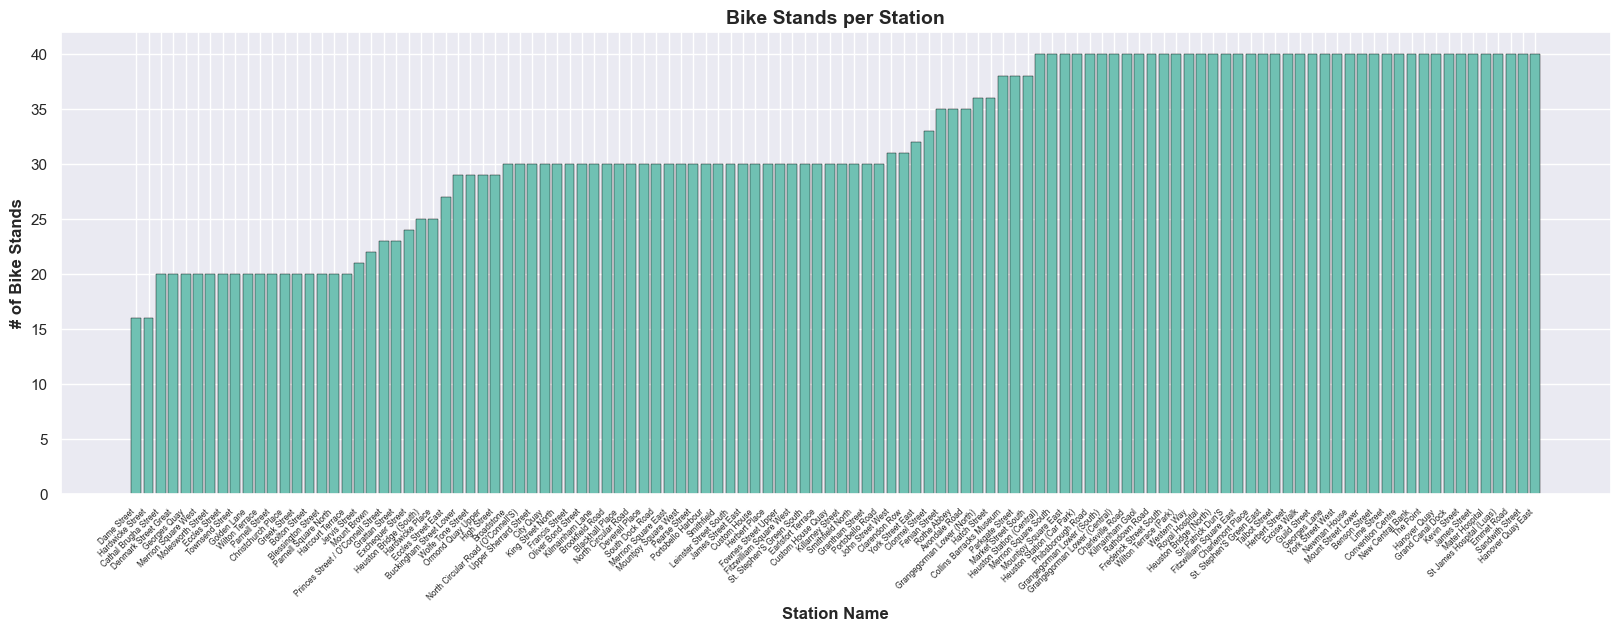

In [6]:
# show distribution of bike stands across the various stations
plt.figure(figsize=(20, 6))
plt.bar(unique_df['NAME'], unique_df['BIKE_STANDS'], color='#70C1B3', edgecolor='black', linewidth=0.3)
plt.xlabel('Station Name', fontsize=12, weight='bold')
plt.ylabel('# of Bike Stands', fontsize=12, weight='bold')
plt.title('Bike Stands per Station', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=6)

plt.show()

In [7]:
# create base map centered on mean of co-ords
map_centre = [unique_df['LATITUDE'].mean(), unique_df['LONGITUDE'].mean()]
map = fl.Map(location=map_centre, zoom_start=14)

# add pin for each location
for _, row in unique_df.iterrows():
    fl.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"{row['NAME']}"
    ).add_to(map)

map.save('map.html')
map

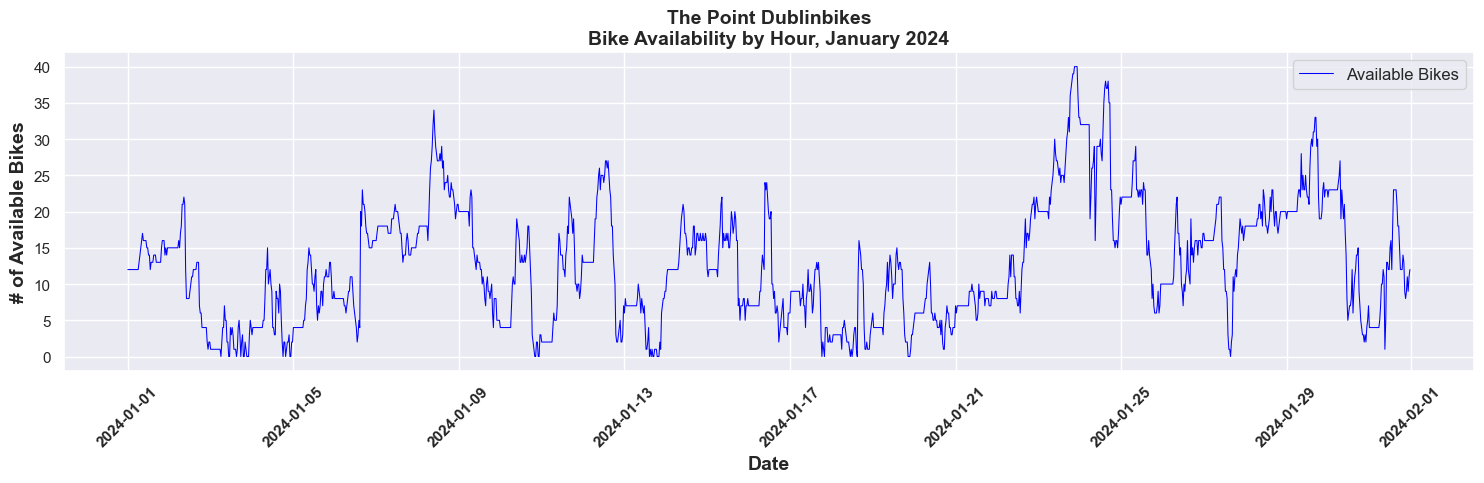

In [8]:
point_df = df[df['NAME'] == 'The Point']
time = point_df['TIME']
bikes = point_df['AVAILABLE_BIKES']

# plot the data
plt.figure(figsize=(15, 5))
plt.plot(time, bikes, label='Available Bikes', color='blue', linewidth=0.75)

# customize the plot
plt.title('The Point Dublinbikes\nBike Availability by Hour, January 2024', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('# of Available Bikes', fontsize=14, weight='bold')
plt.legend(fontsize=12, loc=1)
plt.xticks(rotation=45, weight='bold')

# show the plot
plt.tight_layout()
plt.show()

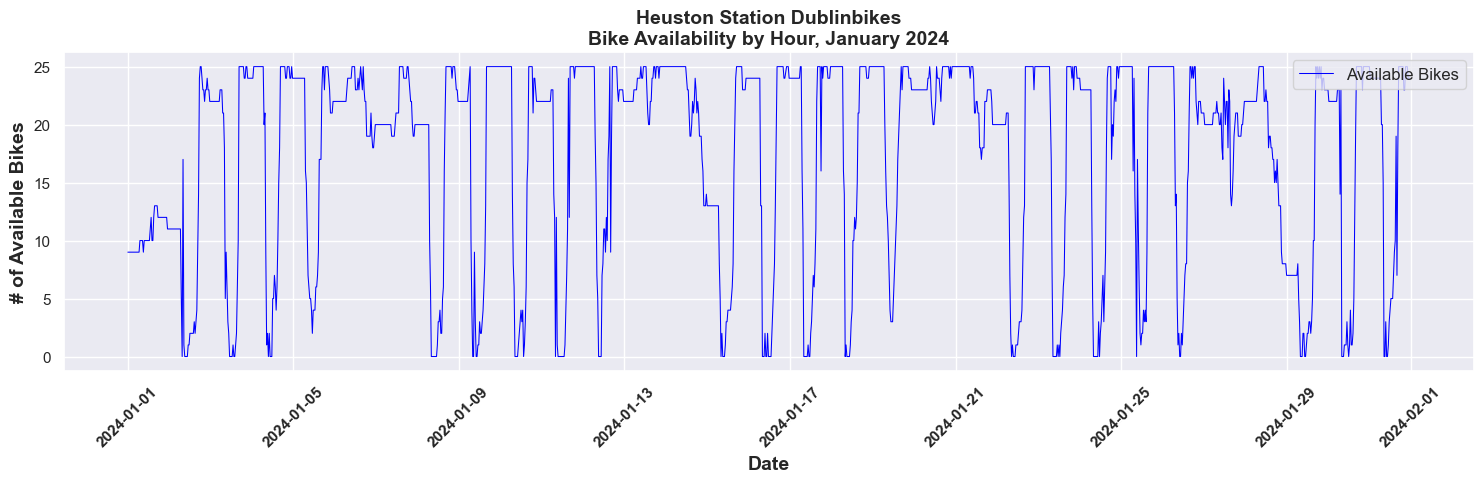

In [9]:
heuston_df = df[df['NAME'] == 'Heuston Bridge (South)']
time = heuston_df['TIME']
bikes = heuston_df['AVAILABLE_BIKES']

# plot the data
plt.figure(figsize=(15, 5))
plt.plot(time, bikes, label='Available Bikes', color='blue', linewidth=0.75)

# customize the plot
plt.title('Heuston Station Dublinbikes\nBike Availability by Hour, January 2024', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('# of Available Bikes', fontsize=14, weight='bold')
plt.legend(fontsize=12, loc=1)
plt.xticks(rotation=45, weight='bold')

# show the plot
plt.tight_layout()
plt.show()

In [11]:
heuston_df.set_index('TIME', inplace=True)
daily_avg = heuston_df['AVAILABLE_BIKES'].resample('D').mean()



KeyError: "None of ['TIME'] are in the columns"